<a href="https://colab.research.google.com/github/tocom242242/aifx_blog_codes/blob/master/pandas/rci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install oandapyV20

In [2]:
# api関連の読み込み
# import json
# keys = json.load(open('/content/drive/MyDrive/oanda_keys.json', 'r'))
# access_token = keys["access_token"]

access_token = "*************"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from scipy.stats import rankdata

In [4]:
def get_close_list(instrument="USD_JPY"):
    """
        終値の取得
    """
    api = API(
        access_token=access_token,
        environment="practice")  # live, もしくは、practice

    params = {
        "granularity": "M5",
        "count": 200,
        "price": "B",
    }

    instruments_candles = instruments.InstrumentsCandles(
        instrument=instrument, params=params)

    api.request(instruments_candles)
    response = instruments_candles.response
    close_list = np.array([x["bid"]["c"] for x in response["candles"]])
    close_list = close_list.astype(np.float64)
    return close_list

In [5]:
def compute_rci(close_list, interval=14):
    """
        rciの計算
    """
    rci_list = [None for _ in range(interval)]

    nb_close = len(close_list)
    for idx in range(nb_close):
        if (idx + interval > nb_close):
            break

        y = close_list[idx:idx + interval]
        x_rank = np.arange(len(y))
        y_rank = rankdata(y, method='ordinal') - 1
        sum_diff = sum((x_rank - y_rank)**2)
        rci = (1 - ((6 * sum_diff) / (interval**3 - interval))) * 100
        rci_list.append(rci)
    return rci_list

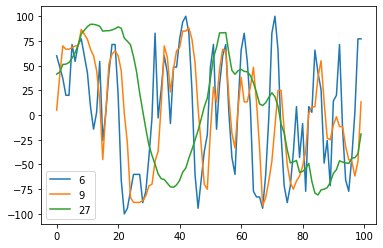

In [6]:
close_list = get_close_list()   # 終値の取得

nb_display = 100    # 表示する期間

# rciを計算する(期間はてきとう)
rci6 = compute_rci(close_list, interval=6)[-nb_display:]    # 短期
rci9 = compute_rci(close_list, interval=9)[-nb_display:]    # 中期
rci27 = compute_rci(close_list, interval=27)[-nb_display:]  # 長期

# rciを表示する
fig, ax = plt.subplots()
x = np.arange(len(rci6))
ax.plot(x, rci6, label="6")
ax.plot(x, rci9, label="9")
ax.plot(x, rci27, label="27")
ax.legend()

plt.savefig("rci.png")
plt.show()